## Data Exploration

In [44]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [45]:
# Importing and Cleaning:

data = pd.read_excel("new_york_2013.xls", index_col = "Table 8", skiprows = [1, 2, 3, 4], skipfooter = 3)

data = data.rename(columns = {'Unnamed: 1': 'Population', 'Unnamed: 2': 'Violent_Crime', 'Unnamed: 3': 'Murder',
                       'Unnamed: 4': 'Rape_1', 'Unnamed: 5': 'Rape_2', 'Unnamed: 6': 'Robbery',
                       'Unnamed: 7': 'Agg_Assault', 'Unnamed: 8': 'Prop_Crime', 'Unnamed: 9': 'Burglary',
                       'Unnamed: 10': 'Larceny_Theft', 'Unnamed: 11': 'Vehicle_Theft', 'Unnamed: 12': 'Arson'})

In [46]:
# Feature Engineering: (Also had to manipulate data_2 a bit because of a 'copy error')

data_2 = pd.DataFrame(data[['Population', 'Murder', 'Robbery', 'Prop_Crime']])

data_2['Cat_Murder'] = data_2.Murder > 0
data_2['Cat_Robbery'] = data_2.Robbery > 0
data_2['Population*2'] = data_2.Population**2
data_2['Mrdr_per_Capita'] = (data_2.Murder / data_2.Population)*5000
data_2['Rob_per_Capita'] = (data_2.Robbery / data_2.Population)*5000
data_2['PropCrime_per_Capita'] = (data_2.Prop_Crime / data_2.Population)*5000

# Looking at instances of property crime when murder/robbery is/is not present.

data_2['PropCrime_Mrdr'] = ((data_2.Prop_Crime > 0) & (data_2.Cat_Murder == True))
data_2['PropCrime_Rob'] =  ((data_2.Prop_Crime > 0) & (data_2.Cat_Robbery == True))  

In [47]:
# Splitting up the data to account for population sizes:

dinky_towns = pd.DataFrame(data_2.loc[data_2['Population'] < 10000])
data_towns = pd.DataFrame(data_2.loc[data_2['Population'] < 100000])
data_nyc = pd.DataFrame(data_2.loc[data_2['Population'] > 1000000])
data_metros = pd.DataFrame(data_2.loc[data_2['Population'] > 100000])
data_NOT_nyc = pd.DataFrame(data_2.loc[data_2['Population'] < 1000000])

In [48]:
# Looking at the per-capita spread in more detail:

all_per_capita = pd.DataFrame(data = {'Mrdr_per_5k': [dinky_towns['Mrdr_per_Capita'].mean(),
                                                data_towns['Mrdr_per_Capita'].mean(),
                                                data_metros['Mrdr_per_Capita'].mean(),
                                                data_nyc['Mrdr_per_Capita'].mean()],       
                                     'Rob_per_5k': [dinky_towns['Rob_per_Capita'].mean(),
                                                data_towns['Rob_per_Capita'].mean(),
                                                data_metros['Rob_per_Capita'].mean(),
                                                data_nyc['Rob_per_Capita'].mean()],
                                     'PropCrime_per_5k': [dinky_towns['PropCrime_per_Capita'].mean(),
                                                data_towns['PropCrime_per_Capita'].mean(),
                                                data_metros['PropCrime_per_Capita'].mean(),
                                                data_nyc['PropCrime_per_Capita'].mean()]},
                             index = ['Dinky Towns', 'Towns', 'Metros', 'NYC'])
all_per_capita

,Mrdr_per_5k,Rob_per_5k,PropCrime_per_5k
Dinky Towns,0.022590,0.853908,89.134788
Towns,0.047214,1.671916,96.369524
Metros,0.504638,13.960737,156.424488
NYC,0.199497,11.415979,84.545539


It is interesting to look at this dissection of the population since Manhattan actually has a lower average Property Crime Rate than the rest of its cohort.  This could be biased since it could be harder to accurately report every instance of Property Crime the larger a city gets.  Nonetheless, looking at more breakdowns of the population size could be helpful - especially in consideration with Robbery since it looks as if the correlation between this and Property Crime is stronger than that of population and murder.

In [49]:
# Looking at these instances even more closely:

coincidence_matrix = pd.DataFrame({'Murder': [(data_2.loc[data_2['Murder'] < 1]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Murder'] < 2]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Murder'] < 3]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Murder'] < 4]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Murder'] < 5]).PropCrime_per_Capita.mean()],
                                  'Robbery' : [(data_2.loc[data_2['Robbery'] < 1]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Robbery'] < 2]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Robbery'] < 3]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Robbery'] < 4]).PropCrime_per_Capita.mean(),
                                              (data_2.loc[data_2['Robbery'] < 5]).PropCrime_per_Capita.mean()]})
coincidence_matrix

,Murder,Robbery
0,91.563145,58.856144
1,94.073957,72.788176
2,93.973566,79.309042
3,95.011705,83.038345
4,95.031456,84.941714


As you can see here, the per-capita murder rate stays the same, while Property Crime shows a consistent increase with the number of robberies experienced.  This indicates a variable we will want to look at further. At this point, it seems as if Robbery and Population might be better to take into consideration instead of Murder.

In [50]:
data_2.Robbery.describe()

count      348.000000
mean        72.902299
std       1031.032873
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max      19170.000000
Name: Robbery, dtype: float64

Obviously there is a lot of variation here since 75% of the data is below 5 occurrences, but the mean is 72.9. This is perhaps due to population size, but also perhaps other items which may or may not be a variable in our dataset.  As such, it is still worthwhile to look at the number of Robberies, in correspondence with the population size, to see how rates change / how these variables correlate.

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


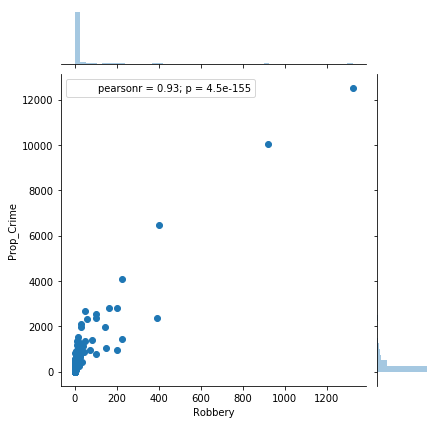

In [51]:
# There are still too many outliers from the 'Robbery' category here even if we take out NYC. 

sns.jointplot(x = 'Robbery', y = 'Prop_Crime', data = data_NOT_nyc)


In [52]:
# So, taking a look at groups of Robberies - divided into a few quantitative categories:

over_1000 = data_2[data_2['Robbery'] >= 1000]
bw_300_999 = data_2[(data_2['Robbery'] > 300) & (data_2['Robbery'] < 1000)]
bw_101_299 = data_2[(data_2['Robbery'] >= 100) & (data_2['Robbery'] < 299)]
bw_50_100 = data_2[(data_2['Robbery'] >= 50) & (data_2['Robbery'] < 100)]
bw_6_49 = data_2[(data_2['Robbery'] >= 6)&(data_2['Robbery'] <= 49)]
under_25 = data_2[data_2['Robbery'] < 25]
over_25 = data_2[data_2['Robbery'] > 25]
zero_five = data_2[(data_2['Robbery'] >= 0)&(data_2['Robbery'] <= 5)]

In [53]:
# You can see that there are some interesting variations when you divide it up by number of robbery instances:
# The functions below can be used with the variables above to see the distribution and correlation of robbery and
# PropCrime.  Since the number of robberies could be considered continuous or categorical depending on how we divide
# the data, the functions give some different ways to visualize this data.

def Rob_PropCrime_Scatter(dataset):
    sns.jointplot(x = 'Robbery', y = 'Prop_Crime', data = dataset)
    
def Rob_PropCrime_StripPlot(dataset):
    sns.stripplot(x = 'Robbery', y = 'Prop_Crime', data = dataset, jitter = True)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


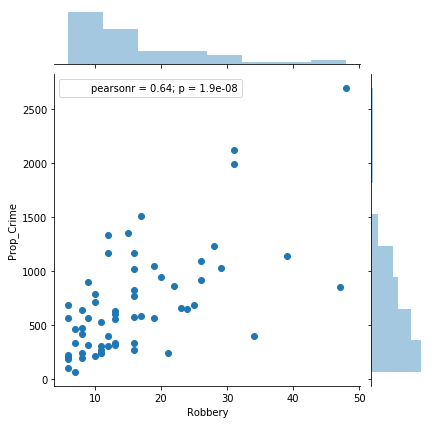

In [54]:
Rob_PropCrime_Scatter(bw_6_49)

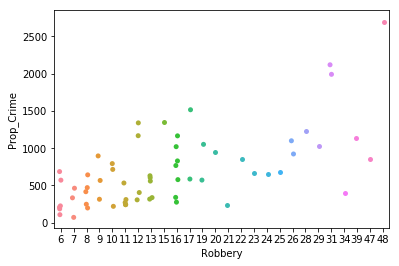

In [55]:
Rob_PropCrime_StripPlot(bw_6_49)

In [56]:
# This table is interesting since the correlation between robberies and property crime stops after you move past
# 50 robberies, but under 50 you still have a relatively strong correlation.

data_2[(data_2['Robbery'] > 6) & (data_2['Robbery'] < 50)].describe()

,Population,Murder,Robbery,Prop_Crime,Population*2,Mrdr_per_Capita,Rob_per_Capita,PropCrime_per_Capita
count,56.000000,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,31817.732143,0.517857,17.125000,735.517857,1.491067e+09,0.089518,3.388258,127.798419
std,22077.206218,0.762557,9.605041,509.076133,2.388250e+09,0.139230,2.026692,57.880559
min,6582.000000,0.000000,7.000000,72.000000,4.332272e+07,0.000000,0.516031,22.604546
25%,16115.750000,0.000000,10.750000,336.250000,2.597294e+08,0.000000,1.970871,93.244260
50%,27874.500000,0.000000,14.000000,617.000000,7.769920e+08,0.000000,3.062128,125.858327
75%,36815.750000,1.000000,21.250000,966.750000,1.355448e+09,0.142305,4.167906,161.110112
max,118296.000000,4.000000,48.000000,2689.000000,1.399394e+10,0.614307,12.154360,319.184717


If you wanted to get a stronger correlation between these variables, you could remove some outliers like Cheektowaga Town, but that would depend on whether or not you want to consider those separately, find more data with similar characteristics or run into potential overfitting, etc.

## Creating the Model

In [57]:
# Looking at some regression/residual plots of the variables we want to consider:

def regression_1(dataset):
    x = sns.regplot(x = 'Robbery', y = 'Prop_Crime', data = dataset, fit_reg = True)
    
def regression_2(dataset):
    y = sns.regplot(x = 'Population', y = 'Prop_Crime', data = dataset, fit_reg = True)
    
def residuals_1(dataset):
    a = sns.residplot(x = 'Robbery', y = 'Prop_Crime', data = dataset)
    
def residuals_2(dataset):
    b = sns.residplot(x = 'Population', y = 'Prop_Crime', data = dataset)

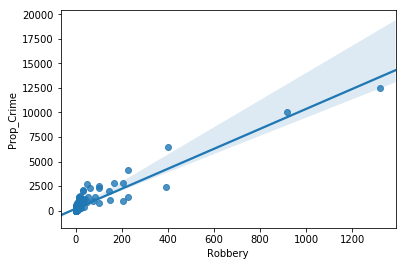

In [58]:
regression_1(data_NOT_nyc)

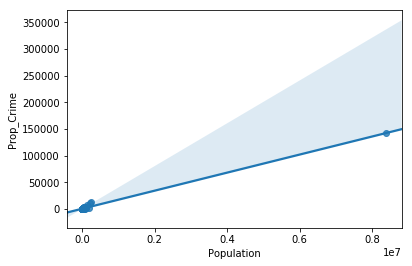

In [59]:
regression_2(data_2)

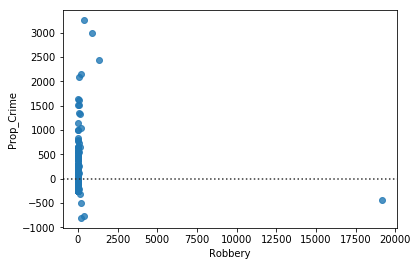

In [60]:
residuals_1(data_2)

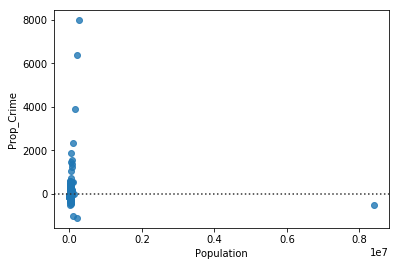

In [61]:
residuals_2(data_2)

Even though this model would be insufficient for a real-world prediction scenario, we can see that there is at least some sort of correlation between robberies, population and property crimes.  We will test this model below

## Testing the Model

For expediency's sake, we will take a look at basing our model off of the number of robberies which occur - according
to the variables/groupings above (which were loosely based on descriptive statistics of the Robbery column.):

In [69]:
Avg_PropCrime_Robbery = pd.DataFrame({'1' : [(data_2[data_2['Robbery'] == 1].Prop_Crime.mean()), (data_2[data_2['Robbery'] == 1].Prop_Crime.std())],
                                      '2' : [(data_2[data_2['Robbery'] == 2].Prop_Crime.mean()), (data_2[data_2['Robbery'] == 2].Prop_Crime.std())],
                                      '3' : [(data_2[data_2['Robbery'] == 3].Prop_Crime.mean()), (data_2[data_2['Robbery'] == 3].Prop_Crime.std())],
                                      '4' : [(data_2[data_2['Robbery'] == 4].Prop_Crime.mean()), (data_2[data_2['Robbery'] == 4].Prop_Crime.std())],
                                      '5' : [(data_2[data_2['Robbery'] == 5].Prop_Crime.mean()), (data_2[data_2['Robbery'] == 5].Prop_Crime.std())],
                                      '6 to 49' : [(bw_6_49.Prop_Crime.mean()), (bw_6_49.Prop_Crime.std())],
                                      '59 to 100' : [(bw_50_100.Prop_Crime.mean()), (bw_50_100.Prop_Crime.std())],
                                      '101 to 299' : [(bw_101_299.Prop_Crime.mean()), (bw_101_299.Prop_Crime.std())],
                                      '300 to 999' : [(bw_300_999.Prop_Crime.mean()), (bw_300_999.Prop_Crime.std())],
                                      'over 1000' : [(over_1000.Prop_Crime.mean()), (over_1000.Prop_Crime.std())]},
                                    index = ['Mean_PropCrime_Robbery', 'Std_Each_Mean'])

In [70]:
Avg_PropCrime_Robbery

,1,2,3,4,5,6 to 49,59 to 100,101 to 299,300 to 999,over 1000
Mean_PropCrime_Robbery,116.178571,243.800000,223.043478,323.0000,351.800000,696.354839,1495.000000,2078.00000,6297.333333,77231.000000
Std_Each_Mean,80.418701,144.781732,182.074530,120.0423,171.855107,502.808118,577.260196,1043.29329,3844.511196,91556.186028


Given this tabel, it seems as if we could build a relatively adequate model for predicting the number of Property Crimes (despite the high variation indicated by the standard deviation) for any city with 1-5 Robberies. Below, we create a function for sorting through the data and creating a 'Model' column.

In [71]:
# Roughly categorizing these numbers for a model:

data_2['Model'] = (((data_2.Robbery == 1) & (data_2.Prop_Crime >= 40) & (data_2.Prop_Crime <= 195)) | 
                   ((data_2.Robbery == 2) & (data_2.Prop_Crime >= 100) & (data_2.Prop_Crime <= 380)) |
                   ((data_2.Robbery == 3) & (data_2.Prop_Crime >= 40) & (data_2.Prop_Crime <= 400)) |
                   ((data_2.Robbery == 4) & (data_2.Prop_Crime >= 200) & (data_2.Prop_Crime <= 440)) |
                   ((data_2.Robbery == 5) & (data_2.Prop_Crime >= 180) & (data_2.Prop_Crime <= 520)))

In [72]:
data_2['Model'].value_counts()

False    255
True      93
Name: Model, dtype: int64

While this gets us some predictions, it doesn't get us nearly close enough to where we need to be.  It would perhaps, be useful to expand our groupings.  Using these numbers in conjunction with population would possibly lead to overfitting, so let's see what happens when we add a few more groups and expand a few others.

In [74]:
# expanding the categories a bit

data_2['Model'] = (((data_2.Robbery == 1) & (data_2.Prop_Crime >= 40) & (data_2.Prop_Crime <= 195)) | 
                   ((data_2.Robbery == 2) & (data_2.Prop_Crime >= 100) & (data_2.Prop_Crime <= 380)) |
                   ((data_2.Robbery == 3) & (data_2.Prop_Crime >= 40) & (data_2.Prop_Crime <= 400)) |
                   ((data_2.Robbery == 4) & (data_2.Prop_Crime >= 200) & (data_2.Prop_Crime <= 440)) |
                   ((data_2.Robbery == 5) & (data_2.Prop_Crime >= 180) & (data_2.Prop_Crime <= 520)) | 
                   ((data_2.Robbery >= 6) & (data_2.Robbery <= 100) & (data_2.Prop_Crime >= 100) & (data_2.Prop_Crime <= 1800)) |
                   ((data_2.Robbery >= 101) & (data_2.Robbery <= 999) & (data_2.Prop_Crime >= 1000) & (data_2.Prop_Crime <= 9000)))

In [75]:
data_2['Model'].value_counts()

False    183
True     165
Name: Model, dtype: int64

In [78]:
# We are nearly at a 50% prediction rate above - perhaps looking at Property Crime per Capita will be more effective:

data_2['Model'] = (((data_2.Robbery == 1) & (data_2.PropCrime_per_Capita >= 50) & (data_2.PropCrime_per_Capita <= 65)) | 
                   ((data_2.Robbery == 2) & (data_2.PropCrime_per_Capita >= 64) & (data_2.PropCrime_per_Capita <= 78)) |
                   ((data_2.Robbery == 3) & (data_2.PropCrime_per_Capita >= 70) & (data_2.PropCrime_per_Capita <= 85)) |
                   ((data_2.Robbery == 4) & (data_2.PropCrime_per_Capita >= 75) & (data_2.PropCrime_per_Capita <= 90)) |
                   ((data_2.Robbery >= 5) & (data_2.PropCrime_per_Capita >= 80) & (data_2.PropCrime_per_Capita <= 90)))

In [79]:
data_2['Model'].value_counts()

False    329
True      19
Name: Model, dtype: int64

It looks like the previous model will do better when cross-validation is applied since this one only predicted 19 out of 329.